In [1]:
import pandas as pd
import numpy as np
import gensim
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE

%matplotlib inline

In [2]:
train_orders = pd.read_csv("../data/raw/order_products__train.csv")
prior_orders = pd.read_csv("../data/raw/order_products__prior.csv")
products = pd.read_csv("../data/raw/products.csv").set_index('product_id')

In [3]:
train_orders["product_id"] = train_orders["product_id"].astype(str)
prior_orders["product_id"] = prior_orders["product_id"].astype(str)

In [4]:
train_products = train_orders.groupby("order_id").apply(lambda order: order['product_id'].tolist())
prior_products = prior_orders.groupby("order_id").apply(lambda order: order['product_id'].tolist())

In [5]:
train_products.head()

order_id
1     [49302, 11109, 10246, 49683, 43633, 13176, 472...
36    [39612, 19660, 49235, 43086, 46620, 34497, 486...
38    [11913, 18159, 4461, 21616, 23622, 32433, 2884...
96    [20574, 30391, 40706, 25610, 27966, 24489, 39275]
98    [8859, 19731, 43654, 13176, 4357, 37664, 34065...
dtype: object

In [6]:
sentences = prior_products.append(train_products).values

In [7]:
prior_products.shape

(3214874,)

In [8]:
model = gensim.models.Word2Vec(sentences, size=100, window=5, min_count=5)

In [10]:
vocab = list(model.wv.vocab.keys())

In [11]:
len(vocab)

47975

In [15]:
vocab[5]

'17794'

In [12]:
def get_batch(vocab, model, n_batches=3):
    output = list()
    for i in range(0, n_batches):
        rand_int = np.random.randint(len(vocab), size=1)[0]
        suggestions = model.most_similar(positive=[vocab[rand_int]], topn=5)
        suggest = list()
        for i in suggestions:
            suggest.append(i[0])
        output += suggest
        output.append(vocab[rand_int])
    return output

def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    """From Tensorflow's tutorial."""
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
#     plt.savefig(filename)
    plt.show()

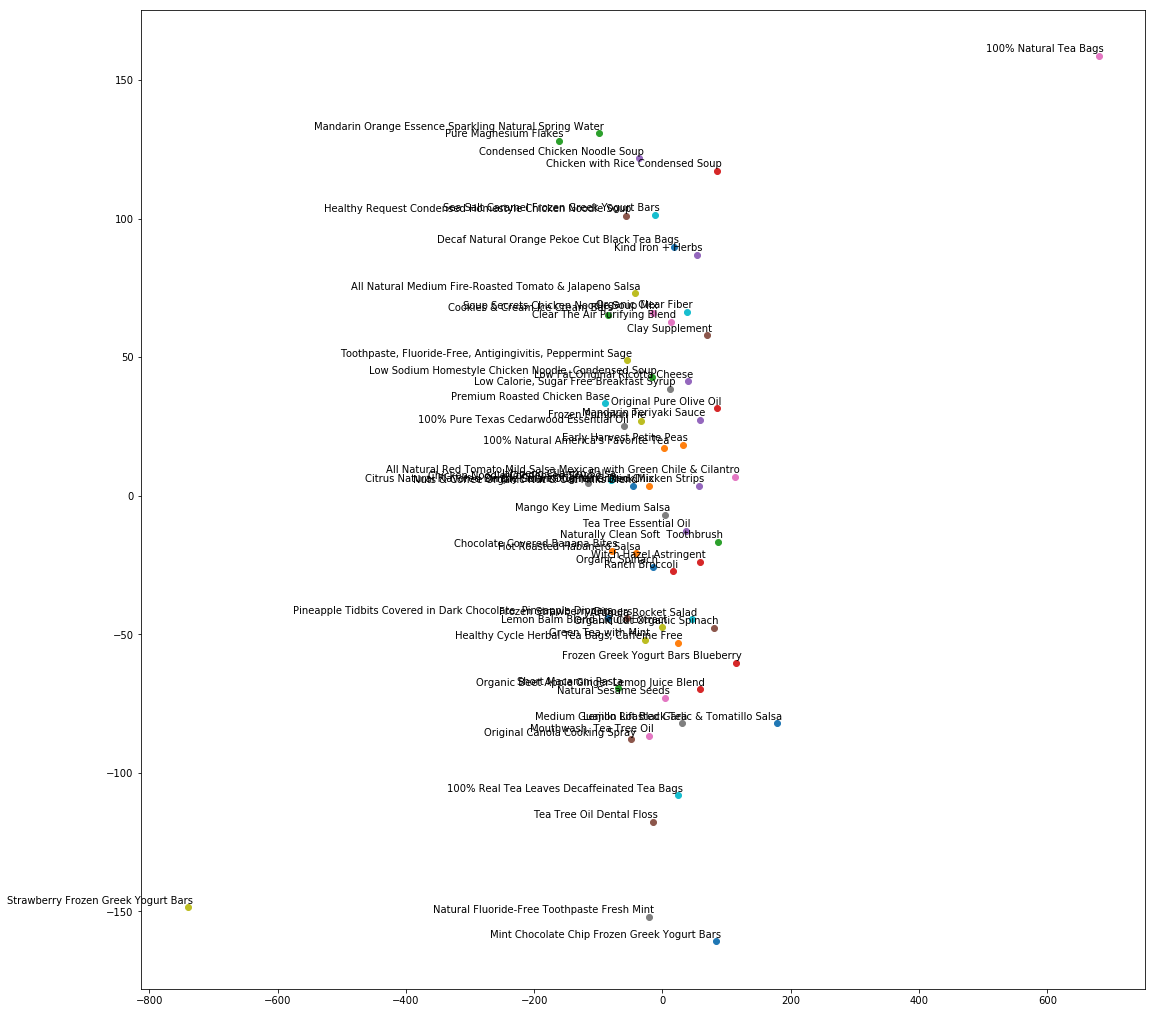

In [16]:
tsne = TSNE()
embeds = []
labels = []
for item in get_batch(vocab, model, n_batches=10):
    embeds.append(model[item])
    labels.append(products.loc[int(item)]['product_name'])
embeds = np.array(embeds)

embeds = tsne.fit_transform(embeds)
plot_with_labels(embeds, labels)

In [18]:
#save the model
model.save("../data/interim/product2vec.model")

In [19]:
products.shape

(49688, 3)

In [21]:
prior_orders.columns

Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered'], dtype='object')